In [3]:
import os.path as op
import sys
sys.path.append(op.abspath('../../'))

sys.path.append(op.abspath('../../../../'))

from os import environ
environ["ANAROOT"] = op.abspath('../../../../')

# Look for other columns

In this notebook, we look for other columns that would be able to take into account the signal shape.

## Libraries

In [4]:
import numpy as np
import models
import var, fcts

from project import files, defs, col
from lib import data, plot as lp


## Simulation

### Parameters

In [5]:
N = 100000
S = 100000
P = 100000


shift_pedestal = (600, 150)
amp_S = 30  # (25, 5)
std_N = 1.

# Peaked
n_peaks = (1, 6)  # between 1 and 6 peaks / event
amp_P = (1, 30)  # peak amplitude between 1 and 15
length_peaks = (1, 3)  # length of a peak between 1 and 3

shift_pedestal = (600, 150)

optimised = False

components = {
    "S": {"S": S, "amp_S": amp_S, "true_pedestal": True},
    "N": {"N": N, "std_N": std_N, "true_pedestal": True},
    "P": {
        "P": P, "n_peaks": n_peaks,
        "amp_P": amp_P, "length_peaks": length_peaks
    }
}

bdt_name = "BDT_SNP"

image_path = op.join(var.image_path, bdt_name)


### Simulation

In [6]:
rng = np.random.default_rng(12345)

dataframe = models.get_full_dataframe(
    components,
    shift_pedestal=shift_pedestal,
    random_time_shift=True,
    rng=rng
)

dataframe = files.compute_voi(
    dataframe,
    variables=defs.computed_variables +
    ['lower_than_mean_cons', 'larger_than_mean_cons',
     'std_pos', 'std_neg', 'nb_pos', 'nb_neg']
)


Time taken: 1.9202723503112793


In [7]:
columns_already_computed = [
    'pos_max', 'pos_min',
    'std',
    'lower_than_mean_cons', 'larger_than_mean_cons',
    'std_pos', 'std_neg',
    'nb_pos', 'nb_neg',
]

columns_to_compute = [
    'max_m_mean', 'min_m_mean', 'pos_max_m_pos_min',
    'mean_m_pedestal',
    'median_m_mean', 'mean_m_std_m_pedestal',
    'std_pos_m_std_neg',
    'nb_pos_m_nb_neg',
    'min_m_pedestal',
    'max_m_pedestal',
    'min_std_pos_neg',
    'max_std_pos_neg',
    'max_std_pos_neg_m_min_std_pos_neg',
    'min_std_pos_neg_red',
    'mean_m_pedestal_red',
    'max_std_pos_neg_red',
    'max_m_mean_red',
    'max_m_pedestal_red',

]

plot_columns = columns_already_computed + columns_to_compute

## Other columns

In [8]:
files.compute_discriminative_voi(dataframe, red=True) 

Time taken: 0.3579978942871094


In [9]:
new_columns = ['mean_before_end_peak', 'mean_before_end_peak_red', 'mean_after_end_peak', 'mean_after_end_peak_red', 'pos_first_neg_after_max']
columns_to_compute += ['mean_before_end_peak_red', 'mean_after_end_peak_red']


### Checking plots

In [10]:
# Get the formula of the columns to compute
formula_columns = col.get_formula_columns(columns_to_compute)
formula_column_labels = col.get_formula_labels(
    columns_to_compute, defs.column_labels
)
column_labels = {**defs.column_labels, **formula_column_labels}

# Compute them
dataframe = data.compute_vals(dataframe, formula_columns)

dict_df = models.get_dict_df(dataframe)
list_compos = ['S', 'N']
list_df = [dict_df[compo] for compo in list_compos]
list_colors, list_labels = fcts.get_list_colors_labels(list_compos)

Fig saved in /home/anthony/3A_CS/projet_ATLAS/output//images/simulation/BDT_SNP/compare_SNP.png
Fig saved in /home/anthony/3A_CS/projet_ATLAS/output//images/simulation/BDT_SNP/compare_SNP.pdf


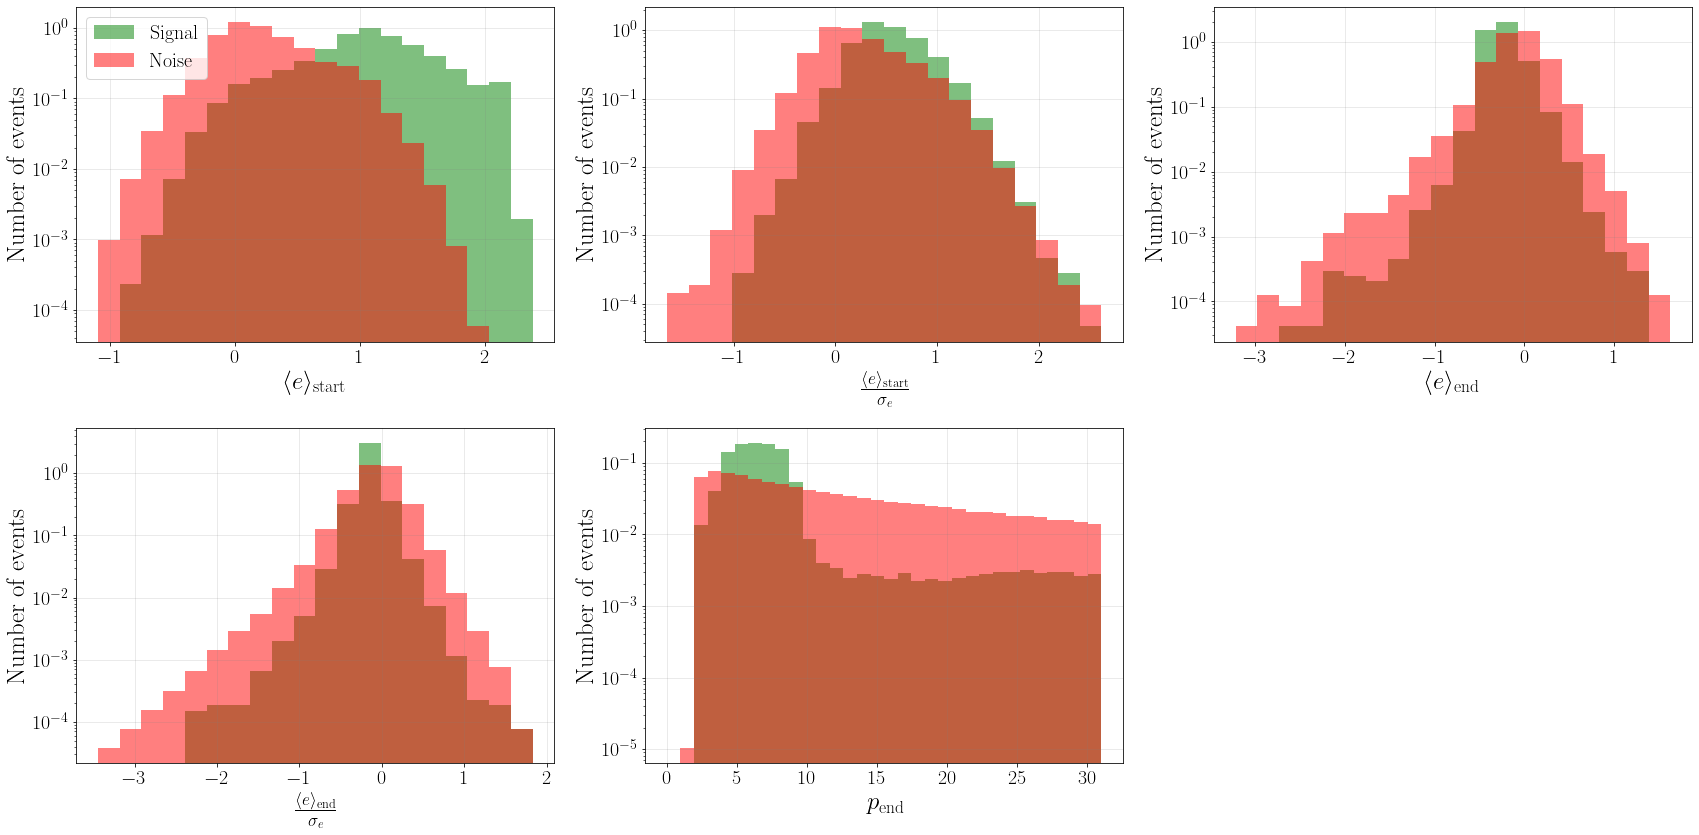

In [11]:
fig, axes = lp.multi_plot_hist(
    list_df, 
    new_columns, column_labels,
    list_colors=list_colors,
    list_labels=list_labels,
    logscale=True,
    nbins={
        'default': 20,
        'pos_first_neg_after_max': 32
    },
    range_columns={
        'default': 20,
        'pos_first_neg_after_max': [0, 31]
    }
)

lp.save_fig(fig, image_path, "compare_SNP")


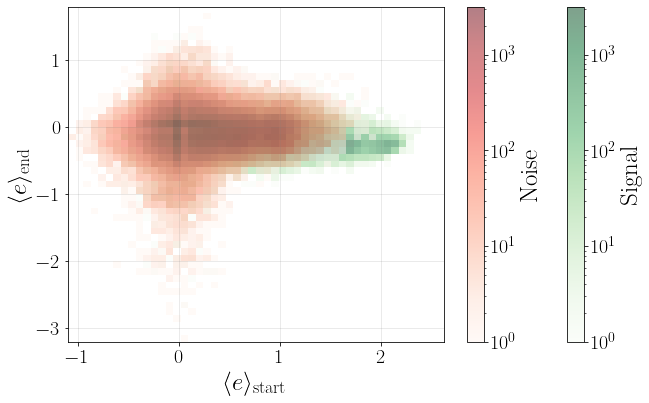

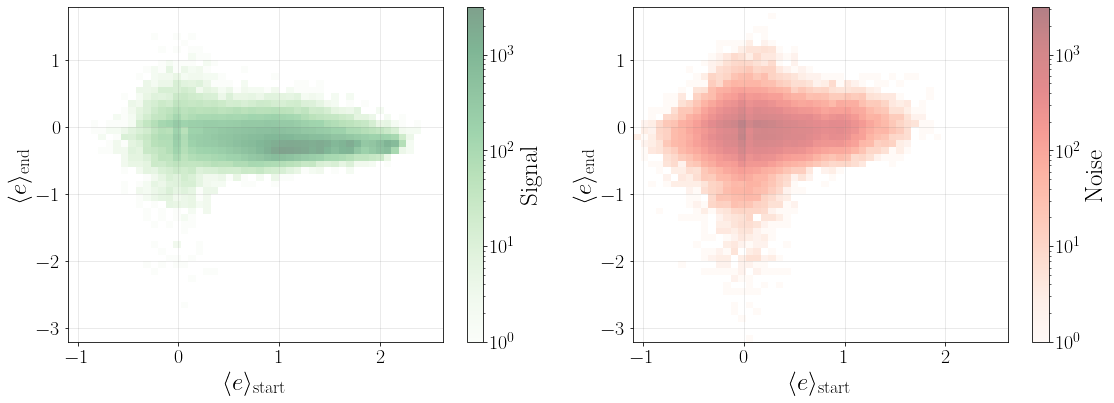

In [12]:
name_var1 = "mean_before_end_peak"
name_var2 = "mean_after_end_peak"

fcts.multi_plot_hist2d_cats(
    dataframe, 
    name_var1, name_var2,
    column_labels[name_var1], column_labels[name_var2],
    list_compos,
)

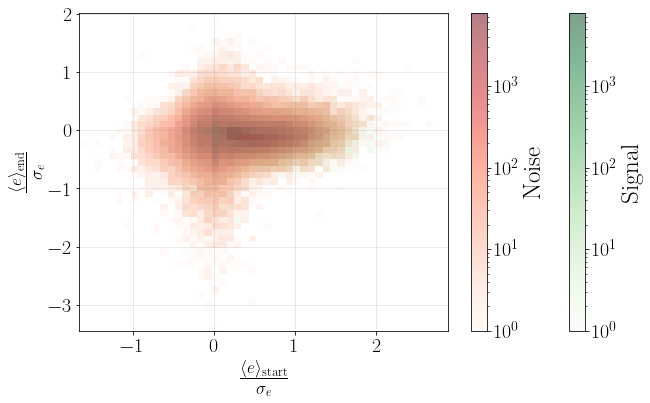

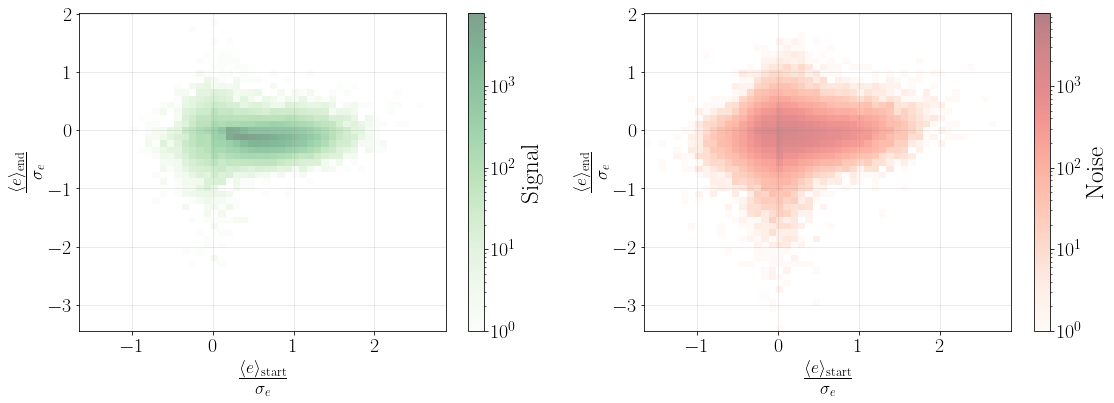

In [13]:
name_var1 = "mean_before_end_peak_red"
name_var2 = "mean_after_end_peak_red"

fcts.multi_plot_hist2d_cats(
    dataframe, 
    name_var1, name_var2,
    column_labels[name_var1], column_labels[name_var2],
    list_compos,
)

By dividing by the standard deviation, we lose amplitude information, which is actually a great indicator of signal or background category.
We might trying clustering with the two 2 variables. We'll first try to tell apart signal and noise (we don't consider the peaked background).